# Import Problem Instance
We start by importing a simple problem instance to demonstrate the tsplib reader.


In [1]:
from tsplib95 import tsplib95
import itertools
import networkx as nx

instance = tsplib95.load_problem('./tsplib/ulysses16.tsp')

instance.comment

'Odyssey of Ulysses (Groetschel/Padberg)'

Remember, this repository contains a small selection of TSP instances that you can use to test your algorithms.

| name | nodes | description |
|------|-------|-------------|
| ulysses16.tsp | 16 | Odyssey of Ulysses |
| ulysses7.tsp | 7 | subset of ulysses16 for testing purposes |
| bayg29.tsp | 29 | 29 Cities in Bavaria |
| bier127.tsp | 127 | 127 Biergaerten in Augsburg |
| bier20.tsp | 20 | subset of bier127 |
| brazil58.tsp | 58 | 58 cities in Brazil |
| ali535.tsp | 535 | 535 Airports around the globe |
| d18512.tsp | 18512 | 18512 places in Germany |

The following calls show the dimension = number of nodes of the problem, its node set and the edge weights. The functions `instance.get_nodes()` and `instance.get_edges()` are implemented as iterators, so you can loop over the nodes or edges. To get a list of nodes or edges, you have to explicitly construct one using `list(instance.get_nodes())`. Note that node counting may start at 1 for some instances while others use 0 as starting point. For convenience, we store the index of the first node as `first_node`.


In [2]:
instance.dimension

instance.get_nodes()
print("List of nodes: ", list(instance.get_nodes()))

first_node = min(instance.get_nodes())
first_node

for i,j in instance.get_edges():
    if i >= j:
        continue
    print(f"edge {{ {i:2},{j:2} }} has weight {instance.wfunc(i,j):3}.")


List of nodes:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
edge {  1, 2 } has weight   6.
edge {  1, 3 } has weight   5.
edge {  1, 4 } has weight   3.
edge {  1, 5 } has weight  11.
edge {  1, 6 } has weight   8.
edge {  1, 7 } has weight   7.
edge {  1, 8 } has weight   1.
edge {  1, 9 } has weight  12.
edge {  1,10 } has weight   8.
edge {  1,11 } has weight  26.
edge {  1,12 } has weight   5.
edge {  1,13 } has weight   5.
edge {  1,14 } has weight   5.
edge {  1,15 } has weight   7.
edge {  1,16 } has weight   1.
edge {  2, 3 } has weight   1.
edge {  2, 4 } has weight   4.
edge {  2, 5 } has weight  17.
edge {  2, 6 } has weight  14.
edge {  2, 7 } has weight  13.
edge {  2, 8 } has weight   6.
edge {  2, 9 } has weight  17.
edge {  2,10 } has weight  13.
edge {  2,11 } has weight  32.
edge {  2,12 } has weight  11.
edge {  2,13 } has weight  11.
edge {  2,14 } has weight  11.
edge {  2,15 } has weight  13.
edge {  2,16 } has weight   7.
edge {  3, 4 } has weight   5

You have already seen how to draw a graph, here is the relevant code again.

In [3]:
G = instance.get_graph()
if instance.is_depictable():
    pos = {i: instance.get_display(i) for i in instance.get_nodes()}
else:
    pos = nx.drawing.layout.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='#66a3ff', node_size=200)
nx.draw_networkx_labels(G, pos, font_weight='bold' )
nx.draw_networkx_edges(G, pos,  edge_color='#e6e6e6')

/Users/ritter/Library/Caches/pypoetry/virtualenvs/assignments-ma4502-S2019-py3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


# Implementing a multi commodity flow model in Gurobi
We will implement a multi commodity flow model using binary variables $x_{ij} \in \{0,1\}$ to indicate whether edge $\{i,j\}$ is being used in the tour. For the flow we use variables $y_{i,j,k}$ indicating the flow of commodity $k$ from node $v_0$ into node $k$ along arc $(i,j)$. Flow is only allowed on arcs that are used in the tour and the capacity of each such arc is $1$, we send $2$ units of flow from $v_0$ to $k$. For the formulation, we employ the condition that $i < j$ for any edge $\{i,j\}$ for the $x$-variables. The formulation looks like this:

\begin{align}
\min\;&\sum_{i,j \in E} c_{i,j} \cdot x_{i,j}\\
&\sum_{j \ne i} x_{i,j} = 2 \quad \text{for all nodes $i$}\\
&\sum_{j \ne k} y_{v_0,j,k} = 2 \quad \text{for all nodes $k \ne v_0$}\\
&\sum_{j \ne k} y_{j,v_0,k} = 0 \quad \text{for all nodes $k \ne v_0$}\\
&\sum_{j \ne i} y_{j,i,k} - \sum_{j \ne i} y_{i,j,k} = 0 \quad \text{for all nodes $k \ne v_0$ and all nodes $i \notin \{v_0,k\}$}\\
&y_{i,j,k} \le x_{i,j} \quad \text{for all arcs $(i,j)$ and all $k \ne v_0$}\\
&y_{j,i,k} \le x_{i,j} \quad \text{for all arcs $(i,j)$ and all $k \ne v_0$}\\
&x_{i,j} \in \{0,1\}\\
&y_{i,j,k} \ge 0 \quad \text{for all $k \ne 1$}
\end{align}

## Creating the variables
We start by creating the model and the variables and setting the objective.


In [4]:
import gurobipy as grb

model = grb.Model(name="Multi Commodity Flow TSP Formulation")
model.reset()

x = model.addVars(filter(lambda e: e[0] < e[1], instance.get_edges()), vtype=grb.GRB.BINARY, name="x")

y = model.addVars(filter(lambda e: e[0] != e[1], instance.get_edges()), range(first_node+1, instance.dimension+1), name="y")

model.setObjective(sum(x[i,j]*instance.wfunc(i,j) for i,j in x.keys()))


Academic license - for non-commercial use only


## Degree Constraints
We first add the degree constraints for the $x$-variables:
\begin{align}
&\sum_{j \ne i} x_{i,j} = 2 \quad \text{for all nodes $i$}
\end{align}

In [5]:
for i in instance.get_nodes():
    model.addConstr(x.sum(i,'*') + x.sum('*',i) == 2, name=f"degree[{i}]")

## Flow Constraints
**Task 1:** Add the flow conservations constraints as well as the in- and out-flow constraints for $v_0$ for each commodity k:

In [6]:
for k in itertools.islice(instance.get_nodes(), 1, None):
    model.addConstr(y.sum(first_node,'*',k) == 2, name=f"v0_outflow_for_commodity_{k}")
    model.addConstr(y.sum('*',first_node,k) == 0, name=f"v0_inflow_for_commodity_{k}")
    for i in filter(lambda e: e not in {first_node,k}, instance.get_nodes()):
        model.addConstr(y.sum('*',i,k) - y.sum(i,'*',k) == 0, name=f"{k}_flow_conservation_at_node_{i}")

## Capacity Constraints
**Task 2:** Add the capacity constraints:
\begin{align}
&y_{i,j,k} \le x_{i,j} \quad \text{for all arcs $(i,j)$ and all $k \ne v_0$}\\
&y_{j,i,k} \le x_{i,j} \quad \text{for all arcs $(i,j)$ and all $k \ne v_0$}
\end{align}

In [7]:
for k in itertools.islice(instance.get_nodes(), 1, None):
    model.addConstrs( (y[i,j,k] <= x[i,j] for i,j in x.keys()), name=f"flow_bound_for_commodity_{k}_on_")
    model.addConstrs( (y[j,i,k] <= x[i,j] for i,j in x.keys()), name=f"reverse_flow_bound_for_commodity_{k}_on_")

## Starting the Optimization Process
Finally, we set the objective to minimization and call the optimizer.

In [8]:
model.ModelSense = grb.GRB.MINIMIZE
model.reset()
model.optimize()

Optimize a model with 3856 rows, 3720 columns and 14190 nonzeros
Variable types: 3600 continuous, 120 integer (120 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Presolve removed 240 rows and 225 columns
Presolve time: 0.02s
Presolved: 3616 rows, 3495 columns, 13305 nonzeros
Variable types: 3375 continuous, 120 integer (120 binary)
Found heuristic solution: objective 124.0000000

Root relaxation: objective 7.050000e+01, 2402 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   70.50000    0   10  124.00000   70.50000  43.1%     -    0s
H    0     0                      71.0000000   70.50000  0.70%     -    0s

Explored 1 nodes (2512 simplex iterations) in 0.17 seconds
Thread count was 8 (of 8 available processors)

Solution count 

## Querying and Visualizing the Solution
Before we visualize our result, let us look at a few key figures of our solution.

In [9]:
model.ObjVal

solution_edges = [(i,j) for i,j in x.keys() if x[i,j].x > 0.9]
solution_edges

flow_edges = [f"({i},{j},{k}): {y[i,j,k].x}" for i,j,k in y.keys() if y[i,j,k].x > 0]
flow_edges

['(1,3,2): 1.0',
 '(1,3,3): 1.0',
 '(1,3,4): 1.0',
 '(1,3,5): 1.0',
 '(1,3,6): 1.0',
 '(1,3,7): 1.0',
 '(1,3,8): 1.0',
 '(1,3,9): 1.0',
 '(1,3,10): 1.0',
 '(1,3,11): 1.0',
 '(1,3,12): 1.0',
 '(1,3,13): 1.0',
 '(1,3,14): 1.0',
 '(1,3,15): 1.0',
 '(1,3,16): 1.0',
 '(1,16,2): 1.0',
 '(1,16,3): 1.0',
 '(1,16,4): 1.0',
 '(1,16,5): 1.0',
 '(1,16,6): 1.0',
 '(1,16,7): 1.0',
 '(1,16,8): 1.0',
 '(1,16,9): 1.0',
 '(1,16,10): 1.0',
 '(1,16,11): 1.0',
 '(1,16,12): 1.0',
 '(1,16,13): 1.0',
 '(1,16,14): 1.0',
 '(1,16,15): 1.0',
 '(1,16,16): 1.0',
 '(2,3,3): 1.0',
 '(2,4,4): 1.0',
 '(2,4,5): 1.0',
 '(2,4,6): 1.0',
 '(2,4,7): 1.0',
 '(2,4,8): 1.0',
 '(2,4,9): 1.0',
 '(2,4,10): 1.0',
 '(2,4,11): 1.0',
 '(2,4,12): 1.0',
 '(2,4,13): 1.0',
 '(2,4,14): 1.0',
 '(2,4,15): 1.0',
 '(2,4,16): 1.0',
 '(3,2,2): 1.0',
 '(3,2,4): 1.0',
 '(3,2,5): 1.0',
 '(3,2,6): 1.0',
 '(3,2,7): 1.0',
 '(3,2,8): 1.0',
 '(3,2,9): 1.0',
 '(3,2,10): 1.0',
 '(3,2,11): 1.0',
 '(3,2,12): 1.0',
 '(3,2,13): 1.0',
 '(3,2,14): 1.0',
 '(3,2,

For debugging purposes, it might be helpful to export the model held by Gurobi into a human-readable format:

In [10]:
model.write('test.lp')

Finally, let us visualize the solution using NetworkX. In this case, we need to prescribe positions and draw the nodes and two layers of edges separately.

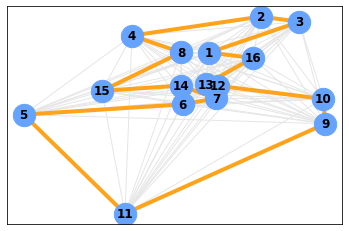

In [12]:
if instance.is_depictable():
    pos = {i: instance.get_display(i) for i in instance.get_nodes()}
else:
    pos = nx.drawing.layout.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='#66a3ff', node_size=500)
nx.draw_networkx_labels(G, pos, font_weight='bold' )
nx.draw_networkx_edges(G, pos,  edge_color='#e6e6e6')
nx.draw_networkx_edges(G, pos,  edgelist=solution_edges, edge_color='#ffa31a', width=4)

**Task 3:** Test the model for different instances. How does it compare to the MTZ formulation?